In [2]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [16]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 200

14.695730957539773


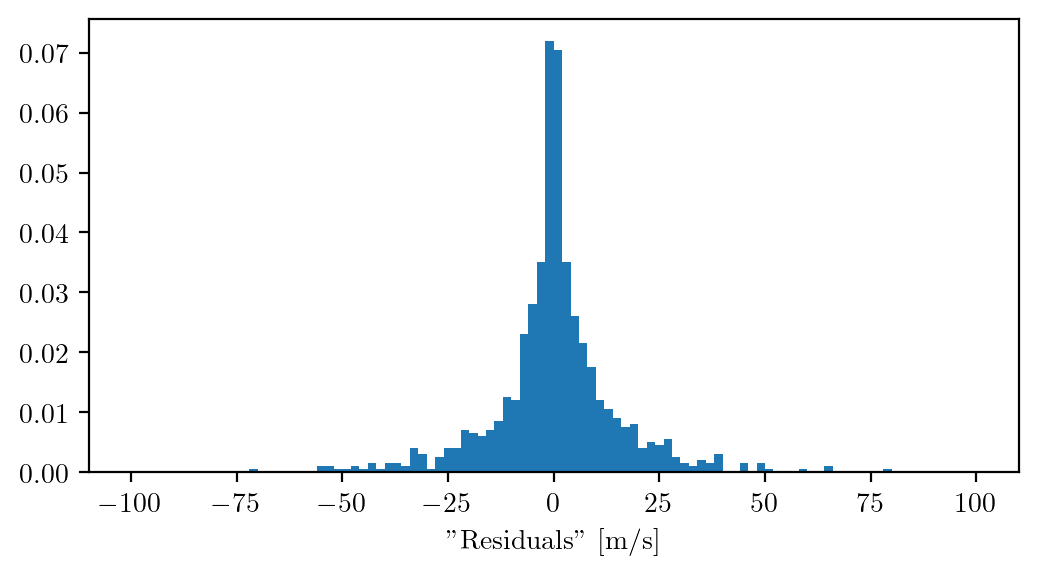

In [40]:

plt.figure(figsize=(6,3))

# Rought representation of the residuals
N_points = 1000
x = np.random.normal(loc=0, scale=5, size=N_points) * np.random.normal(loc=0, scale=3, size=N_points)
plt.hist(x, bins=100, range=(-100, 100), density=True);
plt.xlabel('"Residuals" [m/s]')

# RMS
rms = np.sqrt(1/len(x) * (np.sum(x**2)))
print(rms)


238